## Données

Publication : Ventes mensuelles anticipées pour le commerce de détail et les services de restauration  

Unités :  Millions de dollars, pas d'ajustement de saisonnalité

Fréquence :  Mensuelle

La valeur pour le mois le plus récent est une estimation anticipée qui est basée sur les données d'un sous-échantillon d'entreprises de l'enquête mensuelle sur le commerce de détail, plus importante. L'estimation anticipée sera remplacée au cours des mois suivants par des estimations révisées issues de l'enquête mensuelle sur le commerce de détail, plus vaste. Les séries associées de l'enquête mensuelle sur le commerce de détail sont disponibles à l'adresse suivante : https://fred.stlouisfed.org/series/MRTSSM448USN

Des informations sur l'enquête mensuelle anticipée sur les ventes au détail sont disponibles sur le site web du recensement à l'adresse suivante : https://www.census.gov/retail/marts/about_the_surveys.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# transformer index en date avec parse_dates=True et le mettre en index avec index_col='DATE'
df = pd.read_csv('RSCCASN.csv', parse_dates=True, index_col='DATE')
df.columns = ['Sales'] # renommer la colonne en Sales
df.head()

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


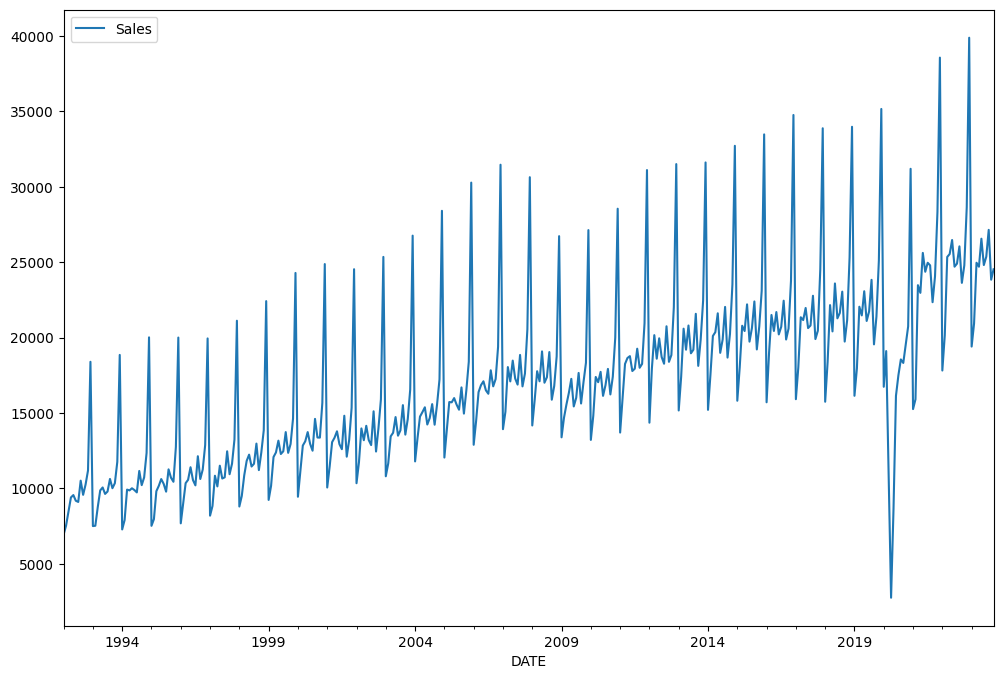

In [3]:
df.plot(figsize=(12,8));

In [4]:
df.shape

(382, 1)

In [5]:
# On va utiliser le test set comme les 18 derniers mois
test_size = 18
test_ind = len(df) - test_size
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [6]:
train # de 1992-01-01 à 2022-04-01

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0
...,...
2021-12-01,38564.0
2022-01-01,17817.0
2022-02-01,20152.0


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [8]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 12 # longueur de la séquence
batch_size = 1 # nombre d'échantillons par lot
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [10]:
def create_model(length, n_features):
    model = Sequential()
    model.add(LSTM(150, activation="relu", input_shape=(length, n_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model

n_features = 1
model = create_model(length, n_features)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 150)           91200     
                                                                 
 dropout (Dropout)           (None, 12, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               100400    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)
model.fit(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])
epochs_processed = len(model.history.epoch)

Epoch 1/20


C:\Users\hajdaini\AppData\Local\Temp\ipykernel_11364\3319478051.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])



352/352 [==============================] - 6s 9ms/step - loss: 0.0295 - val_loss: 0.0214
Epoch 2/20
352/352 [==============================] - 3s 7ms/step - loss: 0.0204 - val_loss: 0.0087
Epoch 3/20
352/352 [==============================] - 3s 8ms/step - loss: 0.0156 - val_loss: 0.0013
Epoch 4/20
352/352 [==============================] - 3s 7ms/step - loss: 0.0110 - val_loss: 0.0154
Epoch 5/20
352/352 [==============================] - 3s 8ms/step - loss: 0.0094 - val_loss: 0.0202
Epoch 6/20
352/352 [==============================] - 3s 7ms/step - loss: 0.0141 - val_loss: 0.0019


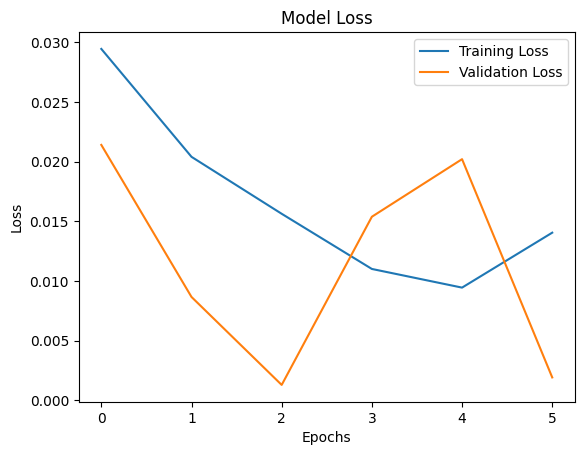

In [12]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 30ms/step


C:\Users\hajdaini\AppData\Local\Temp\ipykernel_11364\3963278392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


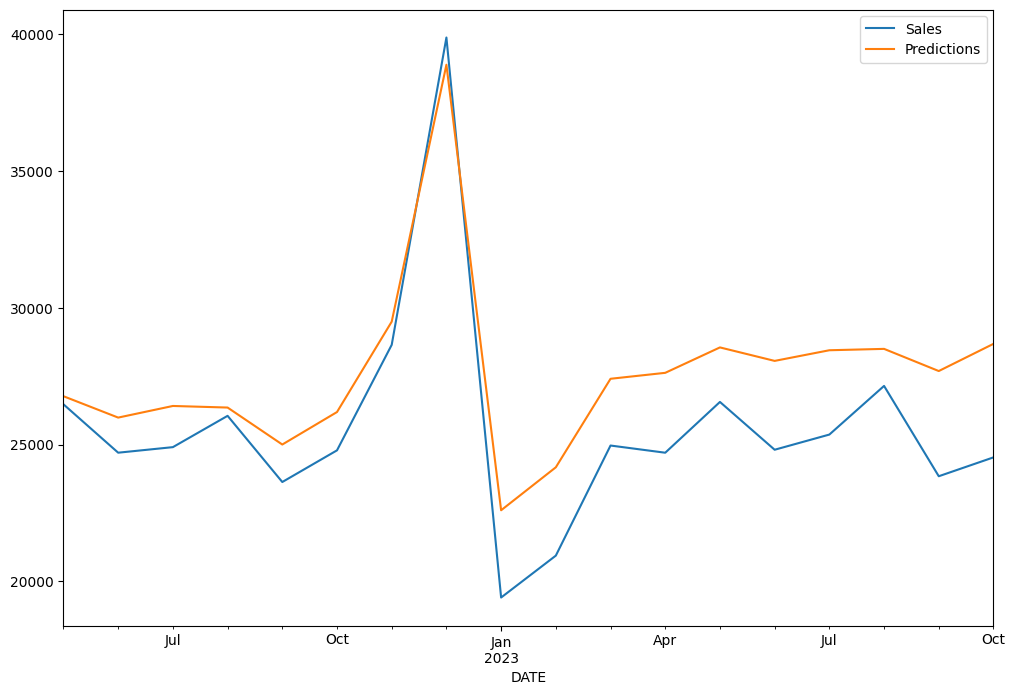

In [13]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(12,8));

In [14]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=batch_size)

In [15]:
n_features = 1
model = create_model(length, n_features)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 150)           91200     
                                                                 
 dropout_3 (Dropout)         (None, 12, 150)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               100400    
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [16]:
model.fit(generator, epochs=epochs_processed)

Epoch 1/6


370/370 [==============================] - 6s 7ms/step - loss: 0.0236
Epoch 2/6
370/370 [==============================] - 3s 7ms/step - loss: 0.0200
Epoch 3/6
370/370 [==============================] - 3s 8ms/step - loss: 0.0162
Epoch 4/6
370/370 [==============================] - 3s 8ms/step - loss: 0.0103
Epoch 5/6
370/370 [==============================] - 3s 7ms/step - loss: 0.0103
Epoch 6/6
370/370 [==============================] - 3s 8ms/step - loss: 0.0080


In [17]:
forecast = []
periods = 12 # nombre de mois à prédire
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 32ms/step


In [18]:
last_index = df.index[-1]
start = last_index + pd.DateOffset(months=1)
print(df.tail())
print("Date de fin de notre Dataframe", last_index)
print("Nouvelle date de départ de notre prédiction", start)
forecast = scaler.inverse_transform(forecast)
forecast_index = pd.date_range(start=start,periods=periods,freq='MS')
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])
forecast_df

              Sales
DATE               
2023-06-01  24809.0
2023-07-01  25364.0
2023-08-01  27143.0
2023-09-01  23840.0
2023-10-01  24530.0
Date de fin de notre Dataframe 2023-10-01 00:00:00
Nouvelle date de départ de notre prédiction 2023-11-01 00:00:00


,Forecast
2023-11-01,29117.728443
2023-12-01,50049.187662
2024-01-01,20036.465842
2024-02-01,21430.604549
2024-03-01,25031.232047
2024-04-01,24888.540878
2024-05-01,26857.281138
2024-06-01,25107.683503
2024-07-01,25786.734489
2024-08-01,27795.578892


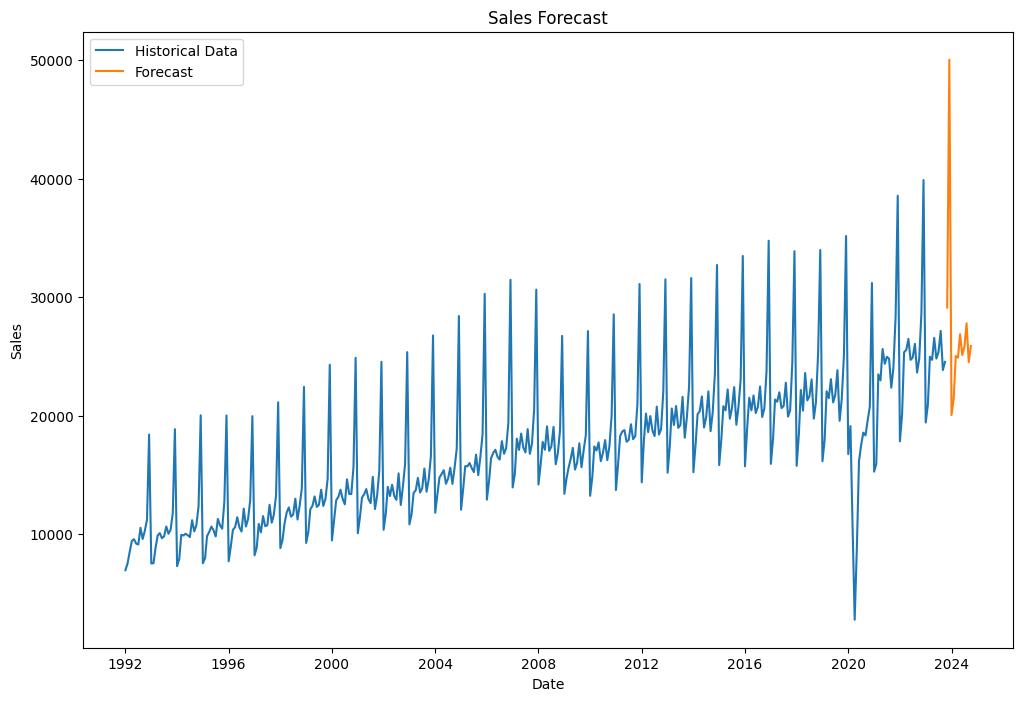

(610.0, 657.0)

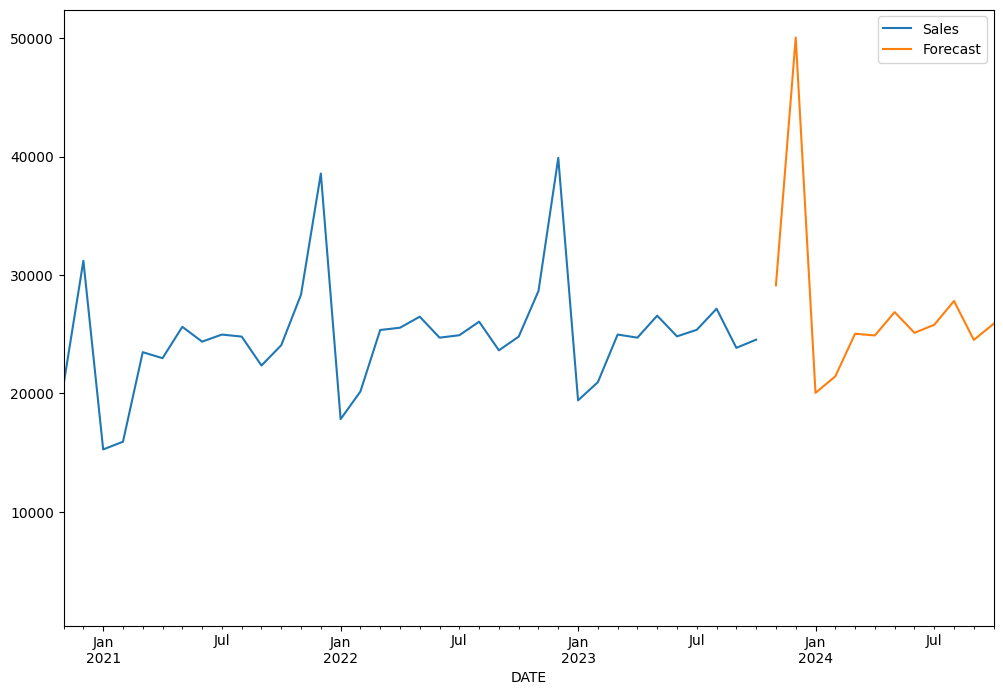

In [20]:
combined_data = pd.concat([df, forecast_df])

# Plot the combined data
plt.figure(figsize=(12, 8))
plt.plot(combined_data.index, combined_data['Sales'], label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast')
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

ax = df.plot(figsize=(12,8))
forecast_df.plot(ax=ax)
plt.xlim(df.tail(36).index[0], forecast_df.index[-1]) # 3 dernières années + 1 an de prédictions

